In [1]:
import pandas as pd
import re

In [2]:
def parse_log_line(line: str) -> dict:
    # Extract timestamp
    timestamp_match = re.search(r"\[(.*?)\]", line)
    timestamp = timestamp_match.group(1) if timestamp_match else ""

    # Extract time elapsed
    time_elapsed_match = re.search(r"\((.*?)\)", line)
    time_elapsed = time_elapsed_match.group(1) if time_elapsed_match else ""

    # Extract host name and event name
    parts = line.split()
    host_name = parts[2] if len(parts) > 2 else ""
    event_name = parts[3].rstrip(":") if len(parts) > 3 else ""

    # Extract all {...} blocks
    curly_groups = re.findall(r"\{(.*?)\}", line)

    # Initialize fields
    cpu_id = "0"
    process_details = ""
    kernel_details = ""

    # Extract CPU ID from first group (if present)
    if len(curly_groups) >= 1:
        cpu_match = re.search(r"cpu_id\s*=\s*(\d+)", curly_groups[0])
        cpu_id = cpu_match.group(1) if cpu_match else "0"

    # Clean and assign process/kernel details (remove quotes)
    if len(curly_groups) >= 2:
        process_details = curly_groups[1].replace('"', '').replace("'", "").strip()
    if len(curly_groups) >= 3:
        kernel_details = curly_groups[2].replace('"', '').replace("'", "").strip()

    # Build formatted example string and escape all curly braces for PromptTemplate
    formatted = (
        f"timestamp:{timestamp}, time elapsed: (+{time_elapsed}), Host Name: {host_name}, "
        f"Event Name: {event_name}, Cpu Id: {cpu_id}, process_details: {process_details}, "
        f"kernel_details: {kernel_details}"
    )

    # Escape all braces for safe PromptTemplate use
    escaped_formatted = formatted.replace("{", "{{").replace("}", "}}")

    return {"example": escaped_formatted}

In [3]:
logs = []
with open("kernel_trace_1K.txt", "r") as file:
    for line in file:
        if line.strip():
            try:
                parsed = parse_log_line(line.strip())
                logs.append(parsed)
            except Exception as e:
                print(f"Error parsing line: {line}\n{e}")

In [4]:
logs

[{'example': 'timestamp:06:13:02.227908688, time elapsed: (++?.?????????), Host Name: mendax, Event Name: syscall_entry_accept, Cpu Id: 2, process_details: procname = elasticsearch[m, pid = 11822, tid = 11859, kernel_details: fd = 553, upeer_addrlen = 246916502706640'},
 {'example': 'timestamp:06:13:02.227912438, time elapsed: (++0.000003750), Host Name: mendax, Event Name: syscall_exit_accept, Cpu Id: 2, process_details: procname = elasticsearch[m, pid = 11822, tid = 11859, kernel_details: ret = 576, upeer_sockaddr = 246916502706648, upeer_addrlen = 246916502706640'},
 {'example': 'timestamp:06:13:02.227914646, time elapsed: (++0.000002208), Host Name: mendax, Event Name: syscall_entry_fcntl, Cpu Id: 2, process_details: procname = elasticsearch[m, pid = 11822, tid = 11859, kernel_details: fd = 576, cmd = 3, arg = 50'},
 {'example': 'timestamp:06:13:02.227914980, time elapsed: (++0.000000334), Host Name: mendax, Event Name: syscall_exit_fcntl, Cpu Id: 2, process_details: procname = ela

In [5]:
import pandas as pd
import re

def parse_key_value_block(block):
    """
    Parse a block like 'key1 = val1, key2 = val2' into a dictionary.
    Handles quoted values and removes extra whitespace.
    """
    pattern = re.findall(r'(\w+)\s*=\s*("[^"]*"|[^,]+)', block)
    return {
      key: re.sub(r"\[.*", "", val.strip('"').strip()) if key == "procname" else val.strip('"').strip()
      for key, val in pattern
  }

def parse_lttng_logs(file_path):
    log_pattern = re.compile(
        r"\[(?P<timestamp>[\d:.]+)\] "
        r"\(\+(?P<time_elapsed>[\d.?\?]+)\) "
        r"(?P<host_name>[\w\-.]+) "
        r"(?P<event_name>[\w_]+): "
        r"\{ cpu_id = (?P<cpu_id>\d+) \}, "
        r"\{ (?P<process_details>.*?) \}, "
        r"\{ (?P<kernel_details>.*?) \}"
    )

    records = []

    with open(file_path, 'r') as file:
        for line in file:
            match = log_pattern.match(line.strip())
            if match:
                base = match.groupdict()

                # Flatten process and kernel details
                process_fields = parse_key_value_block(base.pop("process_details"))
                kernel_fields = parse_key_value_block(base.pop("kernel_details"))

                # Combine all fields
                combined = {**base, **process_fields, **kernel_fields}
                records.append(combined)

    return pd.DataFrame(records)

file_path = "kernel_trace_1K.txt"
real_data = parse_lttng_logs(file_path)

In [6]:
real_data['unique_id'] = range(1, len(real_data) + 1)

In [10]:
real_data.at[0, 'time_elapsed'] = "0.000003735"

In [18]:
# Remove any non-numeric characters (if necessary)
real_data['time_elapsed'] = real_data['time_elapsed'].str.replace(r"[^\d.]", "", regex=True)

# Convert to float
real_data['time_elapsed'] = pd.to_numeric(real_data['time_elapsed'], errors='coerce')

In [19]:
real_data.dtypes

,0
timestamp,object
time_elapsed,float64
host_name,object
event_name,object
cpu_id,object
...,...
advice,object
ufd,object
utmr,object
otmr,object


In [21]:
real_data.head(1000)

,timestamp,time_elapsed,host_name,event_name,cpu_id,procname,pid,tid,fd,upeer_addrlen,...,op_enum,event,msg,offset,nbytes,advice,ufd,utmr,otmr,unique_id
0,06:13:02.227908688,3.735000e-06,mendax,syscall_entry_accept,2,elasticsearch,11822,11859,553,246916502706640,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,06:13:02.227912438,3.750000e-06,mendax,syscall_exit_accept,2,elasticsearch,11822,11859,NaN,246916502706640,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
2,06:13:02.227914646,2.208000e-06,mendax,syscall_entry_fcntl,2,elasticsearch,11822,11859,576,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
3,06:13:02.227914980,3.340000e-07,mendax,syscall_exit_fcntl,2,elasticsearch,11822,11859,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
4,06:13:02.227916313,1.333000e-06,mendax,syscall_entry_getsockname,2,elasticsearch,11822,11859,576,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
965,06:13:02.232285404,2.500000e-07,mendax,syscall_exit_sync_file_range,0,lttng-consumerd,14323,14330,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,966
966,06:13:02.232285613,2.090000e-07,mendax,syscall_entry_fadvise64_64,0,lttng-consumerd,14323,14330,35,NaN,...,NaN,NaN,NaN,143360,NaN,4,NaN,NaN,NaN,967
967,06:13:02.232286446,8.330000e-07,mendax,syscall_exit_fadvise64_64,0,lttng-consumerd,14323,14330,35,NaN,...,NaN,NaN,NaN,143360,NaN,4,NaN,NaN,NaN,968
968,06:13:02.232286779,3.330000e-07,mendax,syscall_entry_ioctl,0,lttng-consumerd,14323,14330,34,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,969


In [12]:
!pip install sdv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.3/69.3 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.4/193.4 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.8/84.8 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.

In [13]:
import sdv

print(sdv.version.public)

1.20.1


In [14]:
from sdv.single_table import CTGANSynthesizer

In [15]:
from sdv.metadata import Metadata
from sdv.metadata import SingleTableMetadata
# meta data generation
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(real_data)
metadata.primary_key = "unique_id"
metadata.update_column(column_name="timestamp", sdtype="datetime")
metadata.update_column(column_name="time_elapsed", sdtype="numerical")

In [16]:
metadata.columns

{'timestamp': {'sdtype': 'datetime'},
 'time_elapsed': {'sdtype': 'numerical'},
 'host_name': {'sdtype': 'categorical'},
 'event_name': {'sdtype': 'categorical'},
 'cpu_id': {'sdtype': 'id'},
 'procname': {'sdtype': 'categorical'},
 'pid': {'sdtype': 'categorical'},
 'tid': {'sdtype': 'categorical'},
 'fd': {'sdtype': 'categorical'},
 'upeer_addrlen': {'sdtype': 'categorical'},
 'ret': {'sdtype': 'categorical'},
 'upeer_sockaddr': {'sdtype': 'categorical'},
 'cmd': {'sdtype': 'categorical'},
 'arg': {'sdtype': 'categorical'},
 'usockaddr_len': {'sdtype': 'categorical'},
 'usockaddr': {'sdtype': 'categorical'},
 'level': {'sdtype': 'categorical'},
 'optname': {'sdtype': 'categorical'},
 'optval': {'sdtype': 'categorical'},
 'optlen': {'sdtype': 'categorical'},
 'buf': {'sdtype': 'categorical'},
 'count': {'sdtype': 'categorical'},
 'epfd': {'sdtype': 'categorical'},
 'maxevents': {'sdtype': 'categorical'},
 'timeout': {'sdtype': 'categorical'},
 'sigmask': {'sdtype': 'categorical'},
 's

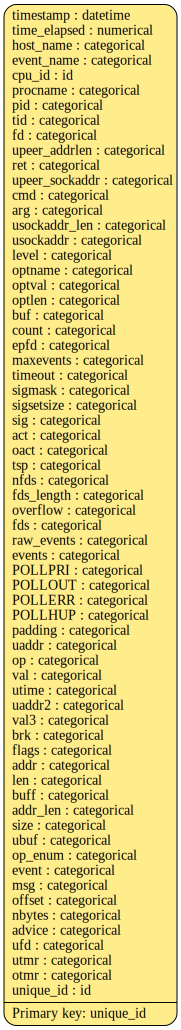

In [26]:
metadata.visualize()

In [22]:
from sdv.single_table import CTGANSynthesizer
# synthesizing data / Training on sample data using CTGAN
synthesizer = CTGANSynthesizer(metadata)
synthesizer.fit(real_data)

/usr/local/lib/python3.11/dist-packages/sdv/single_table/base.py:144: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/usr/local/lib/python3.11/dist-packages/sdv/single_table/base.py:122: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sdv/metadata/single_table.py:1302: UserWarning: No 'datetime_format' is present in the metadata for the following columns:
Column Name   sdtype datetime_format
  timestamp datetime            None
Without this specification, SDV may not be able to accurately parse the data. We recommend adding datetime formats using 'update_column'.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/sdv/_utils.py:55: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`.

In [23]:
synthetic_data = synthesizer.sample(num_rows=1000)
synthetic_data.head()

,timestamp,time_elapsed,host_name,event_name,cpu_id,procname,pid,tid,fd,upeer_addrlen,...,op_enum,event,msg,offset,nbytes,advice,ufd,utmr,otmr,unique_id
0,2025-05-05 06:13:02.232195840,0.000475,mendax,syscall_entry_sync_file_range,2,gnome-shell,14323,14330,NaN,NaN,...,NaN,NaN,NaN,81920,NaN,4,NaN,NaN,NaN,5348437
1,2025-05-05 06:13:02.229909504,0.000542,mendax,syscall_entry_sync_file_range,0,curl,14345,14330,NaN,NaN,...,NaN,NaN,NaN,NaN,4096,NaN,NaN,NaN,NaN,7340150
2,2025-05-05 06:13:02.228835328,0.000000,mendax,syscall_entry_futex,0,lttng-consumerd,11822,14330,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13782587
3,2025-05-05 06:13:02.232285952,0.000000,mendax,syscall_exit_read,3,curl,14323,2972,35,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11806978
4,2025-05-05 06:13:02.229158400,0.000542,mendax,syscall_exit_ioctl,3,lttng-consumerd,2932,14330,34,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12505154


In [24]:
synthetic_data.to_csv("synthetic_logs_sdv.csv", index=False)
print("Data exported to synthetic_logs_sdv.csv")

Data exported to synthetic_logs_sdv.csv


In [41]:
real_data.head()

,timestamp,time_elapsed,host_name,event_name,cpu_id,procname,pid,tid,fd,upeer_addrlen,...,op_enum,event,msg,offset,nbytes,advice,ufd,utmr,otmr,unique_id
0,06:13:02.227908688,3.735000e-06,mendax,syscall_entry_accept,2,elasticsearch,11822,11859,553,246916502706640,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,06:13:02.227912438,3.750000e-06,mendax,syscall_exit_accept,2,elasticsearch,11822,11859,NaN,246916502706640,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
2,06:13:02.227914646,2.208000e-06,mendax,syscall_entry_fcntl,2,elasticsearch,11822,11859,576,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
3,06:13:02.227914980,3.340000e-07,mendax,syscall_exit_fcntl,2,elasticsearch,11822,11859,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
4,06:13:02.227916313,1.333000e-06,mendax,syscall_entry_getsockname,2,elasticsearch,11822,11859,576,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5


In [42]:
synthetic_data.head()

,timestamp,time_elapsed,host_name,event_name,cpu_id,procname,pid,tid,fd,upeer_addrlen,...,op_enum,event,msg,offset,nbytes,advice,ufd,utmr,otmr,unique_id
0,2025-05-05 06:13:02.232195840,0.000475,mendax,syscall_entry_sync_file_range,2,gnome-shell,14323,14330,NaN,NaN,...,NaN,NaN,NaN,81920,NaN,4,NaN,NaN,NaN,5348437
1,2025-05-05 06:13:02.229909504,0.000542,mendax,syscall_entry_sync_file_range,0,curl,14345,14330,NaN,NaN,...,NaN,NaN,NaN,NaN,4096,NaN,NaN,NaN,NaN,7340150
2,2025-05-05 06:13:02.228835328,0.000000,mendax,syscall_entry_futex,0,lttng-consumerd,11822,14330,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13782587
3,2025-05-05 06:13:02.232285952,0.000000,mendax,syscall_exit_read,3,curl,14323,2972,35,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11806978
4,2025-05-05 06:13:02.229158400,0.000542,mendax,syscall_exit_ioctl,3,lttng-consumerd,2932,14330,34,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12505154


In [59]:
synthetic_df = synthetic_data.copy(deep=True)
real_df = real_data.copy(deep=True)

In [60]:
# Converting timestamps to numerical values (seconds since epoch)
real_df['timestamp'] = pd.to_datetime(real_df['timestamp']).astype(int) / 10**9
synthetic_df['timestamp'] = pd.to_datetime(synthetic_df['timestamp']).astype(int) / 10**9

<ipython-input-60-350e5b37e7b5>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  real_df['timestamp'] = pd.to_datetime(real_df['timestamp']).astype(int) / 10**9


In [61]:
real_df["cpu_id"] = pd.to_numeric(real_df["cpu_id"], errors="coerce")

In [62]:
synthetic_df["cpu_id"] = pd.to_numeric(synthetic_df["cpu_id"], errors="coerce")

In [63]:
real_df.head()

,timestamp,time_elapsed,host_name,event_name,cpu_id,procname,pid,tid,fd,upeer_addrlen,...,op_enum,event,msg,offset,nbytes,advice,ufd,utmr,otmr,unique_id
0,1.746426e+09,3.735000e-06,mendax,syscall_entry_accept,2,elasticsearch,11822,11859,553,246916502706640,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,1.746426e+09,3.750000e-06,mendax,syscall_exit_accept,2,elasticsearch,11822,11859,NaN,246916502706640,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
2,1.746426e+09,2.208000e-06,mendax,syscall_entry_fcntl,2,elasticsearch,11822,11859,576,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
3,1.746426e+09,3.340000e-07,mendax,syscall_exit_fcntl,2,elasticsearch,11822,11859,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
4,1.746426e+09,1.333000e-06,mendax,syscall_entry_getsockname,2,elasticsearch,11822,11859,576,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5


In [64]:
synthetic_df.head()

,timestamp,time_elapsed,host_name,event_name,cpu_id,procname,pid,tid,fd,upeer_addrlen,...,op_enum,event,msg,offset,nbytes,advice,ufd,utmr,otmr,unique_id
0,1.746426e+09,0.000475,mendax,syscall_entry_sync_file_range,2,gnome-shell,14323,14330,NaN,NaN,...,NaN,NaN,NaN,81920,NaN,4,NaN,NaN,NaN,5348437
1,1.746426e+09,0.000542,mendax,syscall_entry_sync_file_range,0,curl,14345,14330,NaN,NaN,...,NaN,NaN,NaN,NaN,4096,NaN,NaN,NaN,NaN,7340150
2,1.746426e+09,0.000000,mendax,syscall_entry_futex,0,lttng-consumerd,11822,14330,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13782587
3,1.746426e+09,0.000000,mendax,syscall_exit_read,3,curl,14323,2972,35,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11806978
4,1.746426e+09,0.000542,mendax,syscall_exit_ioctl,3,lttng-consumerd,2932,14330,34,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12505154


In [65]:
synthetic_df.dtypes

,0
timestamp,float64
time_elapsed,float64
host_name,object
event_name,object
cpu_id,int64
...,...
advice,object
ufd,object
utmr,object
otmr,object


In [66]:
import pandas as pd
import numpy as np
from scipy.stats import wasserstein_distance
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score
from scipy.stats import chi2_contingency

In [67]:
from sklearn.preprocessing import LabelEncoder

# Convert categorical columns to strings before encoding
categorical_columns = ["host_name", "event_name", "procname"]
for col in categorical_columns:
    real_df[col] = real_df[col].astype(str)
    synthetic_df[col] = synthetic_df[col].astype(str)

    encoder = LabelEncoder()

    # Fit encoder on combined unique values
    encoder.fit(pd.concat([real_df[col], synthetic_df[col]], axis=0).astype(str))

    # Transform both datasets
    real_df[col] = encoder.transform(real_df[col])
    synthetic_df[col] = encoder.transform(synthetic_df[col])


In [68]:
# ----- 1. Basic Statistical Comparison -----
print("\n--- Basic Statistical Comparison ---")
print("\nReal Data Summary:\n", real_df.describe())
print("\nSynthetic Data Summary:\n", synthetic_df.describe())


--- Basic Statistical Comparison ---

Real Data Summary:
           timestamp  time_elapsed  host_name  event_name      cpu_id  \
count  9.700000e+02  9.700000e+02      970.0  970.000000  970.000000   
mean   1.746426e+09  4.162677e-06        0.0   24.987629    0.588660   
std    1.290041e-03  2.475441e-05        0.0   13.205366    1.066845   
min    1.746426e+09  0.000000e+00        0.0    0.000000    0.000000   
25%    1.746426e+09  2.080000e-07        0.0   11.000000    0.000000   
50%    1.746426e+09  3.330000e-07        0.0   28.000000    0.000000   
75%    1.746426e+09  1.030750e-06        0.0   36.000000    1.000000   
max    1.746426e+09  5.419020e-04        0.0   46.000000    3.000000   

         procname   unique_id  
count  970.000000  970.000000  
mean     8.512371  485.500000  
std      2.889137  280.159181  
min      0.000000    1.000000  
25%     10.000000  243.250000  
50%     10.000000  485.500000  
75%     10.000000  727.750000  
max     12.000000  970.000000  

Syn

In [69]:
# ----- 2. Wasserstein Distance -----
print("\n--- Wasserstein Distance (Numerical Feature Distributions) ---")
for col in ["timestamp", "time_elapsed", "cpu_id"]:
    dist = wasserstein_distance(real_df[col], synthetic_df[col])
    print(f"Wasserstein Distance for {col}: {dist}")


--- Wasserstein Distance (Numerical Feature Distributions) ---
Wasserstein Distance for timestamp: 0.0004560431598388042
Wasserstein Distance for time_elapsed: 0.00012385253573195875
Wasserstein Distance for cpu_id: 0.984340206185567


In [70]:
# ----- 4. Domain Classifier Test -----
print("\n--- Domain Classifier Test (Discriminability) ---")
real_df["label"] = 1  # Real data label
synthetic_df["label"] = 0  # Synthetic data label
combined_df = pd.concat([real_df, synthetic_df])


--- Domain Classifier Test (Discriminability) ---


In [71]:
# Features for classification
features = ["timestamp", "time_elapsed", "cpu_id", "host_name", "event_name"]
X = combined_df[features]
y = combined_df["label"]

In [72]:
# Train-Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a classifier (Random Forest)
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Evaluate classifier
y_pred = clf.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_pred)
print(f"AUC Score (closer to 0.5 means high similarity): {auc_score}")

AUC Score (closer to 0.5 means high similarity): 0.9991976893453145


In [73]:
# ----- 5. Anomaly Detection Test -----
print("\n--- Anomaly Detection Test ---")
iso_forest = IsolationForest(contamination=0.05, random_state=42)
iso_forest.fit(real_df[features])  # Train on real logs

# Predict anomalies in synthetic logs
synthetic_anomaly_scores = iso_forest.decision_function(synthetic_df[features])
anomalies = np.mean(synthetic_anomaly_scores < -0.1) * 100  # % of anomalies
print(f"Percentage of anomalies in synthetic data: {anomalies:.2f}%")


--- Anomaly Detection Test ---
Percentage of anomalies in synthetic data: 28.90%


In [29]:
def dataframe_to_lttng_logs(df, output_file): # converts pandas dataframe to lttng logs.
    with open(output_file, 'w') as file:
        for _, row in df.iterrows():
            timestamp = row['timestamp']
            try:
                time_elapsed = f"+{float(row['time_elapsed']):.9f}" if pd.notna(row['time_elapsed']) else "+?.?????????"
            except ValueError:
                time_elapsed = "+?.?????????"
            event = row['event']
            values = ', '.join(f"{col} = {row[col]}" for col in df.columns[4:] if pd.notna(row[col]))
            log_entry = f"[{timestamp}] ({time_elapsed}) dev-usr-VirtualBox {event}: {{ {values} }}\n"
            file.write(log_entry)

In [30]:
output_log_file = "synthetic_lttng_logs.txt"
dataframe_to_lttng_logs(synthetic_data, output_log_file)
print("Synthetic data exported to LTTng log format in synthetic_lttng_logs.txt")

Synthetic data exported to LTTng log format in synthetic_lttng_logs.txt


In [31]:
import json

In [32]:
synthetic_copy = synthetic_data.copy(deep=True)

In [33]:
def dataframe_to_json(synthetic_copy, output_file):
    synthetic_copy.drop(columns=['unique_id'], inplace=True) # drops uid column
    synthetic_copy.dropna(axis=1, how='all', inplace=True) # drops null columns
    records = synthetic_copy.apply(lambda row: {k: (v.isoformat() if isinstance(v, pd.Timestamp) else v) for k, v in row.items() if pd.notna(v)}, axis=1).tolist()
    with open(output_file, 'w') as file:
        json.dump(records, file, indent=4)
    print(f"Synthetic data exported to JSON format in {output_file}")

In [34]:
output_json_file = "synthetic_lttng_logs.json"
dataframe_to_json(synthetic_copy, output_json_file) # Exports to json file.

Synthetic data exported to JSON format in synthetic_lttng_logs.json
